****Linear Scan of Stacked Waves****

This is for a linear scan (in the y-direction) of points along the rock. We can see how the arrival times of the wave differ before and after where the transducer is.

In [22]:
import numpy as np
import glob
import matplotlib.pyplot as plt

In [ ]:
data_folder = "/path/to/your/files/"
file_pattern = "Test_x0_y*.npy"
files = sorted(glob.glob(data_folder + file_pattern))
arrival_times = {}

time_min = 1.4e-5  
time_max = 2.4e-5 
threshold = 0.02

Calculate arrival times for each point based on a baseline and threshold (again, not super accurate unless you print the graph and see for yourself, and adjust accordingly)

In [24]:
for file in files:
    raw_data = np.load(file)
    data2 = raw_data.reshape((2, -1))
    
    time_array = data2[0, :]
    voltage_array = data2[1, :]

    valid_indices = np.where((time_array >= time_min) & (time_array <= time_max))[0]

    if len(valid_indices) > 0:
        baseline_voltage = np.mean(voltage_array[:valid_indices[0]]) 

        for idx in valid_indices:
            if abs(voltage_array[idx] - baseline_voltage) > threshold:
                arrival_times[file] = time_array[idx]
                break 

for file, arrival_time in arrival_times.items():
    print(f"{file}: {arrival_time:.6e} s")

/Users/Jilli/Documents/Research_2025/Mar4_2025\Test_x0_y0.npy: 2.312483e-05 s
/Users/Jilli/Documents/Research_2025/Mar4_2025\Test_x0_y10.npy: 1.864568e-05 s
/Users/Jilli/Documents/Research_2025/Mar4_2025\Test_x0_y12.npy: 1.848943e-05 s
/Users/Jilli/Documents/Research_2025/Mar4_2025\Test_x0_y14.npy: 1.791652e-05 s
/Users/Jilli/Documents/Research_2025/Mar4_2025\Test_x0_y16.npy: 1.765610e-05 s
/Users/Jilli/Documents/Research_2025/Mar4_2025\Test_x0_y18.npy: 1.739568e-05 s
/Users/Jilli/Documents/Research_2025/Mar4_2025\Test_x0_y2.npy: 2.104150e-05 s
/Users/Jilli/Documents/Research_2025/Mar4_2025\Test_x0_y20.npy: 1.713527e-05 s
/Users/Jilli/Documents/Research_2025/Mar4_2025\Test_x0_y22.npy: 1.567694e-05 s
/Users/Jilli/Documents/Research_2025/Mar4_2025\Test_x0_y24.npy: 1.661444e-05 s
/Users/Jilli/Documents/Research_2025/Mar4_2025\Test_x0_y26.npy: 1.505194e-05 s
/Users/Jilli/Documents/Research_2025/Mar4_2025\Test_x0_y28.npy: 1.479153e-05 s
/Users/Jilli/Documents/Research_2025/Mar4_2025\Test_x0

Stacked Wave Graph

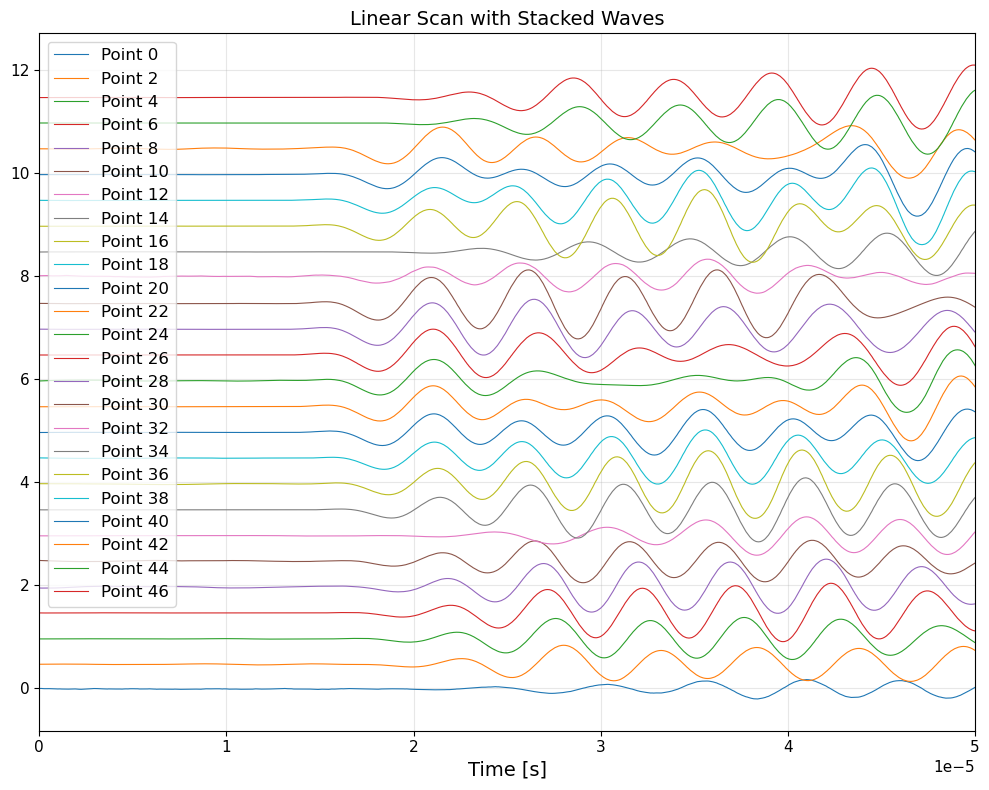

In [25]:
reshaped_data = {}

for file in files:
    raw_data = np.load(file)
    reshaped_data[file] = raw_data.reshape((2, -1))

plt.figure(figsize=(10, 8))

for i, file in enumerate(files): 
    if file in reshaped_data:
        data2 = reshaped_data[file]
        offset = i * 0.5
        time_array = data2[0, :]
        voltage_array = data2[1, :]
        
        plt.plot(time_array, voltage_array + offset, label=f'Point {i*2}', lw=0.8)
        
        valid_indices = np.where((time_array >= time_min) & (time_array <= time_max))[0]
        baseline_voltage = np.mean(voltage_array[:valid_indices[0]]) if len(valid_indices) > 0 else 0

        #for idx in valid_indices:
            #if abs(voltage_array[idx] - baseline_voltage) > threshold:
                #arrival_times[file] = time_array[idx]
                #plt.scatter(time_array[idx], voltage_array[idx] + offset, color='red', zorder=3)
                #break

plt.title("Linear Scan with Stacked Waves", fontsize=14)
plt.xlabel("Time [s]", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12, loc="upper left")
plt.xlim(0, 5e-5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.gca().xaxis.get_offset_text().set_fontsize(11)
plt.show()


I manually picked each arrival time (not recommended for time, but for accuracy, yes) here, and added them to the stacked wave plot

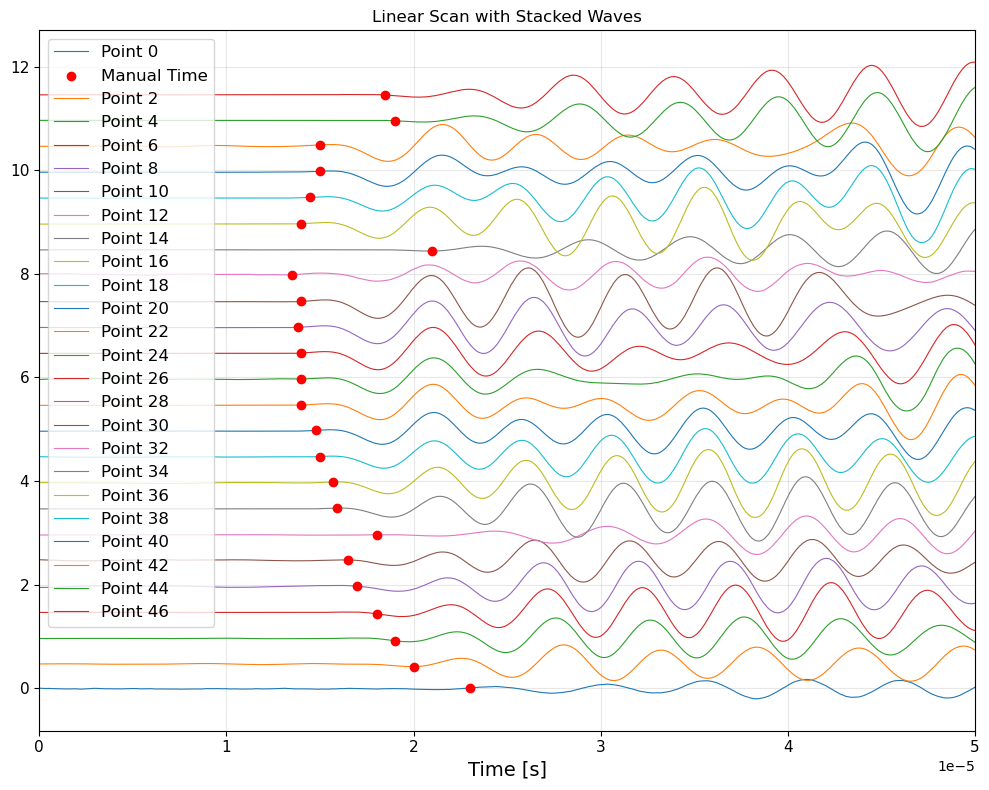

In [26]:
time_min = 1.4e-5  
time_max = 2.4e-5  
manual_times = [2.3e-5, 2e-5, 1.9e-5, 1.8e-5, 1.7e-5, 1.65e-5, 1.8e-5, 1.59e-5, 
                1.57e-5, 1.5e-5, 1.48e-5, 1.4e-5, 1.4e-5, 1.4e-5, 1.38e-5, 1.4e-5,
                1.35e-5, 2.1e-5, 1.4e-5, 1.45e-5, 1.5e-5, 1.5e-5, 1.9e-5, 1.85e-5]

if len(manual_times) != len(files):
    raise ValueError("Length of manual_times must match the number of waves (files).")

plt.figure(figsize=(10, 8))

for i, (file, manual_time) in enumerate(zip(files, manual_times)): 
    if file in reshaped_data:
        data2 = reshaped_data[file]
        offset = i * 0.5 
        time_array = data2[0, :]
        voltage_array = data2[1, :]

        plt.plot(time_array, voltage_array + offset, label=f'Point {i*2}', lw=0.8)

        nearest_idx = np.abs(time_array - manual_time).argmin()  
        plt.scatter(time_array[nearest_idx], voltage_array[nearest_idx] + offset, 
                    color='red', zorder=3, label="Manual Time" if i == 0 else "")

plt.title("Linear Scan with Stacked Waves", fontsize=12)
plt.xlabel("Time [s]", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12, loc="upper left")
plt.xlim(0, 5e-5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


The earliest arrival time is at Point 28, in which we say, that's where the middle of the transducer is

In [27]:
transducer_index = 28  
point_spacing = 2.132e-3  # 1.066mm per point
velocity = 3300  #velocity from rock w/o laser
tinterp = 4.86e-6 #time intercept from laser
thickness = 0.02549 #rock thickness in m
y_points = np.arange(0, 47, 2) * point_spacing  
transducer_y = transducer_index * point_spacing 

These functions indicate a calculated arrival time, based on our values from the above cell

In [28]:
def distance(y):
    vert_dist = abs(y - transducer_y)
    return np.sqrt(thickness**2 + vert_dist**2)

def TravelTimes(y, velocity, tinterp):
    return tinterp + distance(y) / velocity

calculated_travel_times = [TravelTimes(y, velocity, tinterp) for y in y_points]

The calculated arrival times on top of the stacked waves

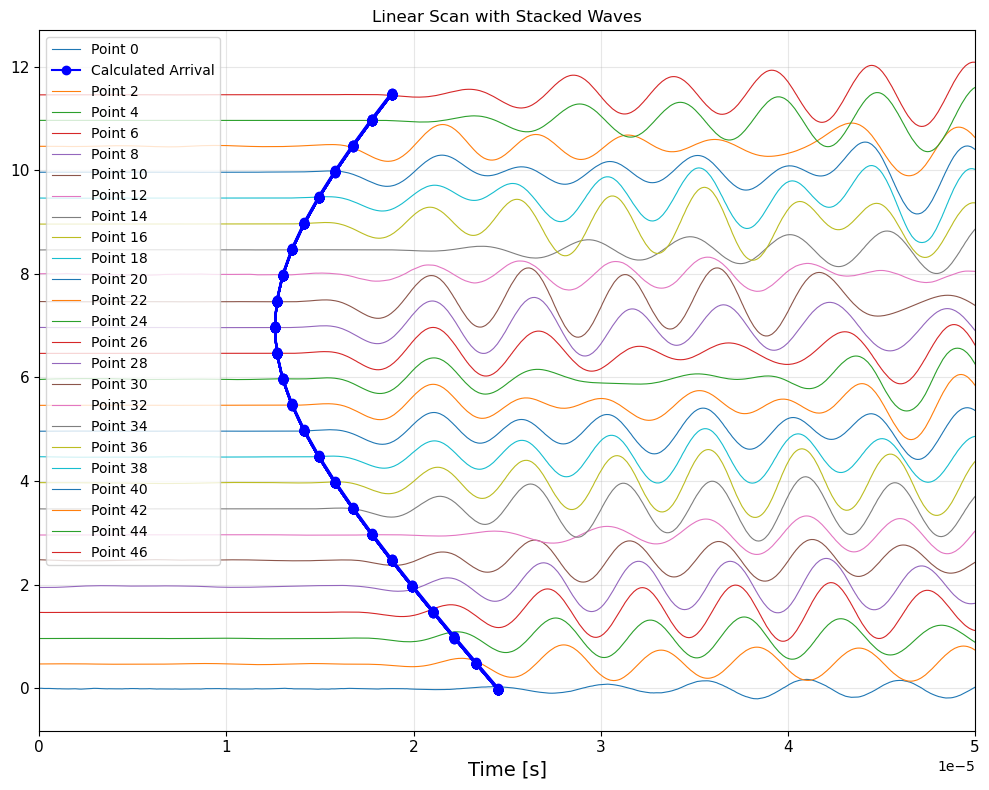

In [29]:
plt.figure(figsize=(10, 8))

for i, file in enumerate(files): 
    raw_data = np.load(file)
    data2 = raw_data.reshape((2, -1))

    offset = i * 0.5
    time_array = data2[0, :]
    voltage_array = data2[1, :]
    
    plt.plot(time_array, voltage_array + offset, label=f'Point {i*2}', lw=0.8)

    if i < len(calculated_travel_times):
        plt.plot(calculated_travel_times, 
         [voltage_array[0] + i * 0.5 for i in range(len(calculated_travel_times))], 
         color='blue', marker='o', linestyle='-', label="Calculated Arrival" if i == 0 else "", zorder=3)

plt.title("Linear Scan with Stacked Waves", fontsize=12)
plt.xlabel("Time [s]", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=10, loc="upper left")
plt.xlim(0, 5e-5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


Actual Arrival times and Calculated Arrival Times

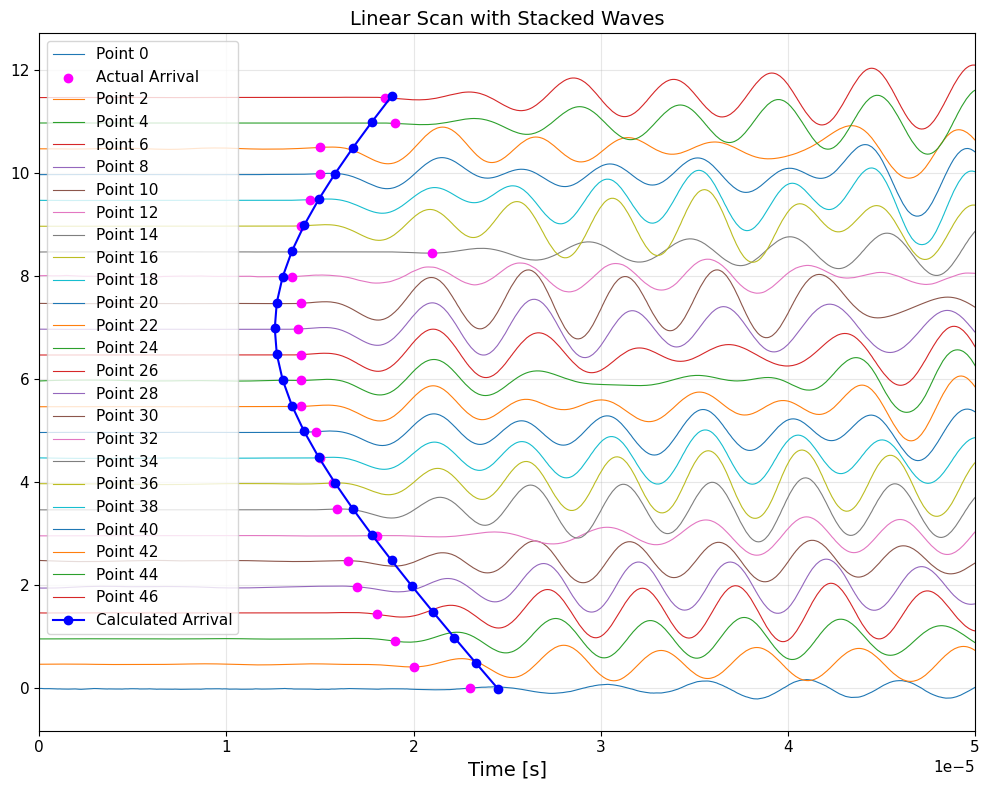

In [30]:
if len(manual_times) != len(files):
    raise ValueError("Length of manual_times must match the number of waves (files).")

reshaped_data = {}
for file in files:
    raw_data = np.load(file)
    reshaped_data[file] = raw_data.reshape((2, -1))

plt.figure(figsize=(10, 8))

for i, (file, manual_time) in enumerate(zip(files, manual_times)): 
    if file in reshaped_data:
        data2 = reshaped_data[file]
        offset = i * 0.5  
        time_array = data2[0, :]
        voltage_array = data2[1, :]

        plt.plot(time_array, voltage_array + offset, label=f'Point {i*2}', lw=0.8)

        nearest_idx = np.abs(time_array - manual_time).argmin()  

        plt.scatter(time_array[nearest_idx], voltage_array[nearest_idx] + offset, 
                    color='magenta', zorder=3, label="Actual Arrival" if i == 0 else "")

plt.plot(calculated_travel_times, 
         [reshaped_data[files[0]][1, 0] + i * 0.5 for i in range(len(calculated_travel_times))], 
         color='blue', marker='o', linestyle='-', label="Calculated Arrival", zorder=3)

plt.title("Linear Scan with Stacked Waves", fontsize=14)
plt.xlabel("Time [s]", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=11, loc="upper left")
plt.xlim(0, 5e-5)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.gca().xaxis.get_offset_text().set_fontsize(11)
plt.show()

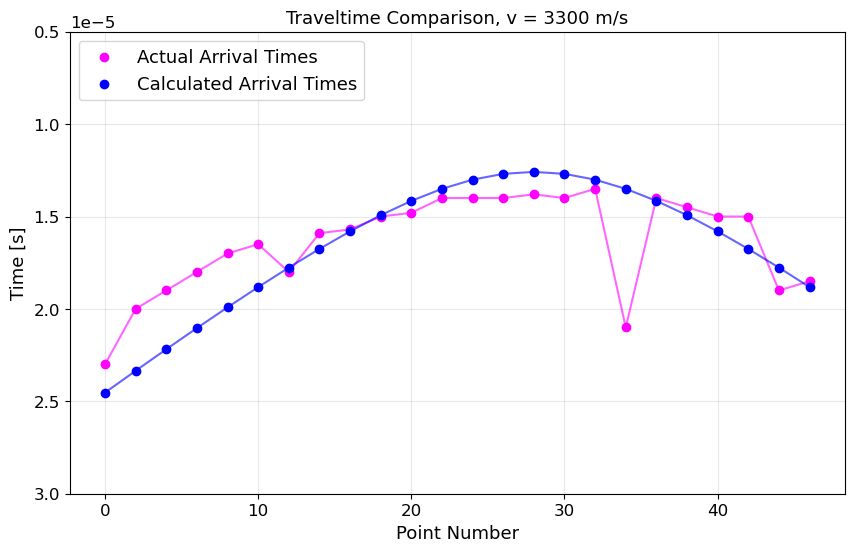

In [31]:
plt.figure(figsize=(10, 6))

x_vals = np.arange(len(manual_times))*2

plt.scatter(x_vals, manual_times, color='magenta', label="Actual Arrival Times", zorder=3)
plt.plot(x_vals, manual_times, color='magenta', linestyle='-', alpha=0.6)

plt.scatter(x_vals[:len(calculated_travel_times)], calculated_travel_times, 
            color='blue', label="Calculated Arrival Times", zorder=3)
plt.plot(x_vals[:len(calculated_travel_times)], calculated_travel_times, 
         color='blue', linestyle='-', alpha=0.6)

plt.xlabel("Point Number", fontsize=13)
plt.ylabel("Time [s]", fontsize=13)
plt.title("Traveltime Comparison, v = 3300 m/s", fontsize=13)
plt.legend(fontsize=13, loc="upper left")
plt.grid(alpha=0.3)
plt.ylim([0.5e-5,3e-5])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()  # Flip y-axis so earlier times are at the top
plt.gca().yaxis.get_offset_text().set_fontsize(12)
plt.show()